In [1]:
import numpy as np
import pandas as pd
from docplex.mp.model import Model
import os
import dimod
from dwave.system import LeapHybridBQMSampler #LeapHybridSampler

In [2]:
# --- Generate couplings ---
def generate_J(N, seed=None):
    # Create directory if it doesn't exist
    os.makedirs('generated_data', exist_ok=True)
    
    if seed is not None:
        np.random.seed(seed)
    std = 1.0 / np.sqrt(N)
    data = [(i, j, np.random.normal(0, std)) for i in range(N) for j in range(i+1, N)]
    df = pd.DataFrame(data, columns=['i','j','Jij'])
    
    if seed is not None:
        filepath = f'generated_data/Jij_N{N}_seed{seed}.csv'
        df.to_csv(filepath, index=False)
        print(f"Saved couplings for N={N} to {filepath}")
    else:
        filepath = f'generated_data/Jij_N{N}.csv'
        df.to_csv(filepath, index=False)
        print(f"Saved couplings for N={N} to {filepath}")

# --- Load couplings ---
def load_J(N, seed=None):
    filename = f'generated_data/Jij_N{N}_seed{seed}.csv' if seed is not None else f'generated_data/Jij_N{N}.csv'
    df = pd.read_csv(filename)
    N = max(df['i'].max(), df['j'].max()) + 1
    return [(int(i), int(j), float(Jij)) for i,j,Jij in df.values], N

### Excited State Sampling Using QPU with Penalty-Biased Annealing

**Strategy: Iterative Orthogonality Penalty Method**

After finding the ground state $|\psi_0\rangle$, we add an orthogonality penalty to force the QPU to find states orthogonal to previously found solutions:

$$H_{\text{orthog}} = H + \beta \sum_{\text{found}} |\langle \psi | \psi_k \rangle|^2$$

**Implementation for Ising spins (±1):**

The squared overlap is:
$$|\langle \psi | \psi_k \rangle|^2 = \left(\frac{1}{N}\sum_i S_i^{(new)} S_i^{(k)}\right)^2 = \frac{1}{N^2} \sum_{i,j} S_i^{(new)} S_j^{(new)} S_i^{(k)} S_j^{(k)}$$

**Key insight:** This is **quadratic** in the current state variables $S_i^{(new)}$, so it CAN be represented in a BQM!

Expanding the sum:
- **Diagonal terms** $(i=j)$: $\frac{1}{N^2}\sum_i (S_i^{(new)})^2 (S_i^{(k)})^2 = \frac{1}{N}$ (constant, since spin² = 1)
- **Off-diagonal terms** $(i \neq j)$: $\frac{1}{N^2}\sum_{i \neq j} S_i^{(new)} S_j^{(new)} S_i^{(k)} S_j^{(k)}$

The off-diagonal terms modify the coupling matrix:
$$J_{ij}^{\text{new}} = J_{ij}^{\text{orig}} - \frac{\beta}{N^2} S_i^{(k)} S_j^{(k)}$$

(Note the minus sign: in $H = -\sum J_{ij} S_i S_j$, subtracting from $J$ increases energy when spins match previous state)

In [4]:
# QPU-BASED EXCITED STATE SAMPLING: Penalty-Biased Annealing
def solve_SK_excited_states_QPU(rows, N, seed=None, K=10, penalty_strength=10.0, time_limit=60):
    """
    Find K lowest energy states using D-Wave QPU with iterative penalty-biased annealing.
    
    After finding ground state |ψ₀⟩, we add orthogonality penalty:
        H_orthog = H + β Σ_found |⟨ψ|ψₖ⟩|²
    
    For Ising spins: |⟨ψ|ψₖ⟩|² = (1/N Σᵢ Sᵢ Sᵢ⁽ᵏ⁾)² = 1/N² Σᵢⱼ Sᵢ Sⱼ Sᵢ⁽ᵏ⁾ Sⱼ⁽ᵏ⁾
    
    This is quadratic in current state variables → can be implemented in BQM!
    
    Parameters:
    -----------
    rows : list of tuples (i, j, Jij)
        Original SK coupling matrix entries (only i<j stored)
    N : int
        Number of spins
    seed : int
        Random seed for disorder instance
    K : int
        Number of lowest energy states to find (default: 10)
    penalty_strength : float
        Strength β of orthogonality penalty (default: 2.0)
    time_limit : int
        Time limit per QPU call in seconds (default: 30)
    
    Returns:
    --------
    energies : list
        List of K energies (physical, without penalty)
    states : list of lists
        List of K spin configurations [S_0, ..., S_{N-1}] with S_i ∈ {-1, +1}
    """
    os.makedirs('dwave_solutions', exist_ok=True)
    
    # Store couplings: J_original for energy calculation, J_bqm for D-Wave
    J_original = {(i, j): Jij for i, j, Jij in rows}
    J_bqm_original = {(i, j): -Jij for i, j, Jij in rows}  # D-Wave minimizes
    
    found_states = []
    found_energies = []
    
    print(f"\n{'='*70}")
    print(f"Finding K={K} excited states with orthogonality penalty (β={penalty_strength})")
    print(f"{'='*70}\n")
    
    for k in range(K):
        print(f"🔍 Finding state {k+1}/{K}...")
        
        # Start with original BQM couplings
        h = {i: 0.0 for i in range(N)}
        J = J_bqm_original.copy()
        
        # Add orthogonality penalty: β |⟨ψ|ψₖ⟩|² = β/N² Σᵢⱼ Sᵢ Sⱼ Sᵢ⁽ᵏ⁾ Sⱼ⁽ᵏ⁾
        # Since BQM only stores (i,j) with i<j, we need factor of 2 for off-diagonal terms
        if found_states:
            print(f"   Adding penalties for {len(found_states)} previous state(s)...")
            for prev_state in found_states:
                for i in range(N):
                    for j in range(i+1, N):
                        # Factor 2 accounts for symmetric (i,j) and (j,i) terms in full sum
                        penalty_coupling = (2.0 * penalty_strength / (N * N)) * prev_state[i] * prev_state[j]
                        J[(i, j)] += penalty_coupling
        
        # Solve modified BQM
        bqm = dimod.BinaryQuadraticModel(h, J, dimod.SPIN)
        sampler = LeapHybridBQMSampler() ###LeapHybridSampler()
        sampleset = sampler.sample(bqm, time_limit=time_limit, label=f"SK_N{N}_seed{seed}_k{k+1}")
        
        # Extract best solution
        best_sample = sampleset.first
        S = [best_sample.sample[i] for i in range(N)]
        
        # Compute physical energy (without penalty)
        E_phys = sum(-Jij * S[i] * S[j] for (i, j), Jij in J_original.items())
        
        found_states.append(S)
        found_energies.append(E_phys)
        
        print(f"   ✓ E_phys = {E_phys:.6f}, E_BQM = {best_sample.energy:.6f}")
        
        # Verify orthogonality
        if len(found_states) > 1:
            overlaps = [sum(S[i] * found_states[m][i] for i in range(N)) / N 
                       for m in range(len(found_states) - 1)]
            print(f"   Overlaps: {[f'{q:.3f}' for q in overlaps]}")
        print()
    
    print(f"{'='*70}")
    print(f"✓ Found K={K} states, E ∈ [{min(found_energies):.6f}, {max(found_energies):.6f}]")
    print(f"{'='*70}\n")
    
    # Save results
    data = [[k, found_energies[k]] + found_states[k] for k in range(K)]
    columns = ['state_index', 'energy'] + [f's_{i}' for i in range(N)]
    df = pd.DataFrame(data, columns=columns)
    filepath = f'dwave_solutions/solution_K{K}_N{N}_seed{seed}_QPU_excited.csv'
    df.to_csv(filepath, index=False)
    print(f"✓ Saved to {filepath}\n")
    
    return found_energies, found_states


### Generate 10 excited for a given sample (seed). We shall generate 5 of the samples or seeds.

In [ ]:
# GOAL 2: Generate M=5 disorder realizations, each with K=10 excited states
N = 1000
M = 5  # Number of disorder realizations
K = 10  # Number of excited states per realization
seeds = [30, 40, 50, 60, 70]  # Different random seeds

all_states = []  # Will store M lists of K states each
all_energies = []  # Will store M lists of K energies each

print(f"Goal 2: Computing overlap distribution for N={N}, M={M}, K={K}")
print(f"Total QPU calls: {M * K} = {M*K}\n")

for m, seed in enumerate(seeds):
    print(f"\n{'#'*70}")
    print(f"# DISORDER REALIZATION {m+1}/{M} (seed={seed})")
    print(f"{'#'*70}\n")
    
    # Generate couplings for this disorder realization
    generate_J(N, seed=seed)
    rows, N = load_J(N, seed=seed)
    
    # Find K=10 excited states for this disorder
    # Penalty strength β scaled with sqrt(N): ensures penalty ~ energy gap between excited states
    # For N=1000: β ≈ 6.3 is optimal (energy gap ~ O(sqrt(N)) ~ 30)
    penalty_strength = 10 ##2.0 * np.sqrt(N / 100)  # ≈ 6.3 for N=1000
    energies, states = solve_SK_excited_states_QPU(rows, N, seed=seed, K=K, 
                                                    penalty_strength=penalty_strength, 
                                                    time_limit=70)
    
    all_states.append(states)
    all_energies.append(energies)

print(f"\n{'='*70}")
print(f"✓✓✓ COMPLETED: Generated {M} disorder realizations with {K} states each")
print(f"✓✓✓ Total states collected: {M*K}")
print(f"{'='*70}\n")

Goal 2: Computing overlap distribution for N=1000, M=5, K=10
Total QPU calls: 50 = 50


######################################################################
# DISORDER REALIZATION 1/5 (seed=30)
######################################################################

Saved couplings for N=1000 to generated_data/Jij_N1000_seed30.csv
Saved couplings for N=1000 to generated_data/Jij_N1000_seed30.csv

Finding K=10 excited states with orthogonality penalty (β=10)

🔍 Finding state 1/10...

Finding K=10 excited states with orthogonality penalty (β=10)

🔍 Finding state 1/10...
   ✓ E_phys = -757.153430, E_BQM = -757.153430

🔍 Finding state 2/10...
   Adding penalties for 1 previous state(s)...
   ✓ E_phys = -757.153430, E_BQM = -757.153430

🔍 Finding state 2/10...
   Adding penalties for 1 previous state(s)...
   ✓ E_phys = -754.900701, E_BQM = -754.549701
   Overlaps: ['0.190']

🔍 Finding state 3/10...
   Adding penalties for 2 previous state(s)...
   ✓ E_phys = -754.900701, E_BQM = -754.5497

# Goal 2: State-Space Overlap Distribution

**Objective:** Characterize the hierarchical energy landscape by computing overlap distribution between low-energy excited states

**Physical Motivation:**
- RSB theory predicts hierarchical energy landscape with multiple competing low-energy states
- Unlike mean-field theory (single state), RSB has exponentially many states with complex overlap structure
- State-space overlaps reveal this hierarchical organization

**Protocol:**
1. Load K=10 lowest-energy states from M=5 disorder realizations  
2. For each disorder, compute all pairwise state overlaps: $q_{\alpha\beta} = \frac{1}{N}\sum_i S_i^{(\alpha)} S_i^{(\beta)}$
3. Pool overlaps across disorders to form empirical distribution P(q)
4. Compare with predictions:
   - **Mean-field:** Sharp peaks (few states)
   - **RSB:** Broad, continuous distribution reflecting hierarchical structure

**Note on State-Space Overlaps:**
- We probe **excited states within one disorder** (energy landscape geometry) at T=0
- This differs from thermal replica overlaps (different thermal samples at T>0)
- Both reveal RSB physics: thermal replicas → frozen disorder; state-space → landscape hierarchy
- For T=0 computational studies, state-space overlaps are standard (Katzgraber 2006, Palassini & Young 2000)
- Expected range: overlaps can span full range [-1, +1], with typical RSB showing broad distribution centered near 0

In [3]:
# Step 1: Load saved states from disk
import numpy as np
import pandas as pd

N = 1000
M = 5
K = 10
seeds = [30, 40, 50, 60, 70]  # Match the seeds used in data generation

print(f"Loading {M} disorder realizations (N={N}, K={K})...\n")
all_states = []

for seed in seeds:
    filepath = f'dwave_solutions/solution_K{K}_N{N}_seed{seed}_QPU_excited.csv'
    df = pd.read_csv(filepath)
    states = df[[f's_{i}' for i in range(N)]].values  # Shape: (K, N)
    all_states.append(states)
    print(f"✓ Loaded seed {seed}")

print(f"\n✓ Successfully loaded {M} × {K} = {M*K} states\n")

Loading 5 disorder realizations (N=1000, K=10)...

✓ Loaded seed 30
✓ Loaded seed 40
✓ Loaded seed 50
✓ Loaded seed 60
✓ Loaded seed 70

✓ Successfully loaded 5 × 10 = 50 states



In [4]:
# Step 2: Compute all pairwise overlaps
all_overlaps = []

for m in range(M):
    for alpha in range(K):
        for beta in range(alpha + 1, K):
            q = np.dot(all_states[m][alpha], all_states[m][beta]) / N
            all_overlaps.append(q)

all_overlaps = np.array(all_overlaps)

print(f"Computed {len(all_overlaps)} overlaps (expected: {M*K*(K-1)//2})")
print(f"Range: [{all_overlaps.min():.3f}, {all_overlaps.max():.3f}]")
print(f"Mean:  {all_overlaps.mean():.3f} ± {all_overlaps.std():.3f}\n")

Computed 225 overlaps (expected: 225)
Range: [-0.506, 0.530]
Mean:  -0.016 ± 0.191



✓ Saved: overlap_distribution.pdf, .png


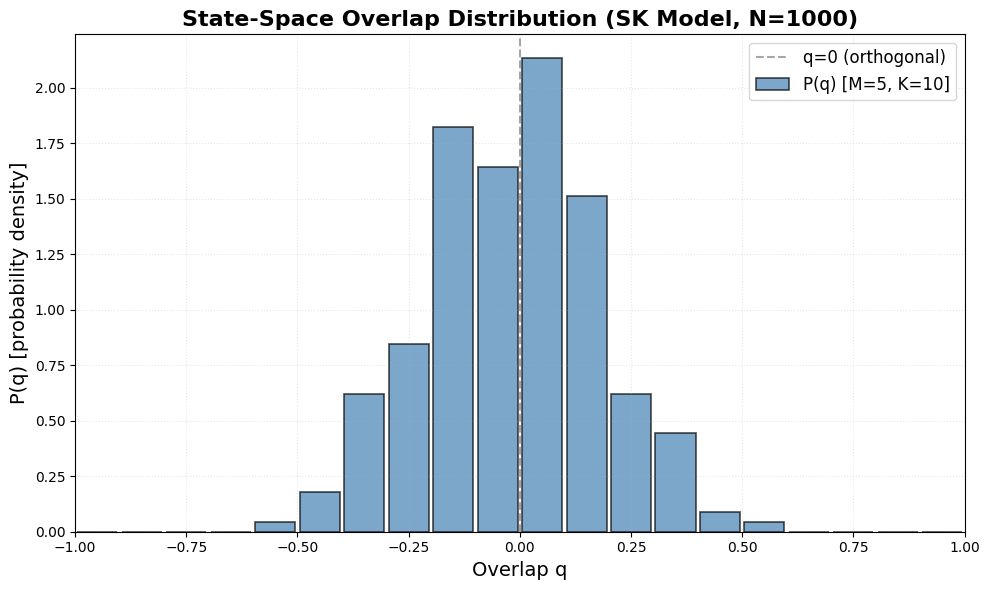


Generating LaTeX PGF version...
✓ Saved: overlap_distribution.pgf (LaTeX format)


In [10]:
# Step 3: Plot overlap distribution P(q) with LaTeX-compatible PGF output
import matplotlib.pyplot as plt
import matplotlib

# First, create the plot with inline display
n_bins = 20
counts, bin_edges = np.histogram(all_overlaps, bins=n_bins, range=(-1, 1), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bin_centers, counts, width=bin_width*0.9, alpha=0.7, 
       color='steelblue', edgecolor='black', linewidth=1.2, label=f'P(q) [M={M}, K={K}]')
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='q=0 (orthogonal)')

ax.set_xlabel('Overlap q', fontsize=14)
ax.set_ylabel('P(q) [probability density]', fontsize=14)
ax.set_title(f'State-Space Overlap Distribution (SK Model, N={N})', fontsize=16, fontweight='bold')
ax.set_xlim(-1, 1)
ax.grid(True, alpha=0.3, linestyle=':')
ax.legend(fontsize=12, loc='upper right')

plt.tight_layout()

# Save standard formats first
plt.savefig('overlap_distribution.pdf', dpi=300, bbox_inches='tight')
plt.savefig('overlap_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: overlap_distribution.pdf, .png")

# Display the figure inline
plt.show()

# Now create LaTeX/PGF version separately
print("\nGenerating LaTeX PGF version...")
matplotlib.use('pgf')  # Switch to PGF backend

# Configure matplotlib for LaTeX
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 13,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# Recreate plot for PGF
fig_pgf, ax_pgf = plt.subplots(figsize=(7, 5))
ax_pgf.bar(bin_centers, counts, width=bin_width*0.9, alpha=0.7, 
           color='steelblue', edgecolor='black', linewidth=1.2, label=f'$P(q)$ [$M={M}$, $K={K}$]')
ax_pgf.axvline(x=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='$q=0$ (orthogonal)')

ax_pgf.set_xlabel(r'Overlap $q = \frac{1}{N}\sum_i S_i^{(\alpha)} S_i^{(\beta)}$', fontsize=16)
ax_pgf.set_ylabel(r'$P(q)$ [probability density]', fontsize=16)
# ax_pgf.set_title(f'State-Space Overlap Distribution (SK Model, $N={N}$)', fontsize=14, fontweight='bold')
ax_pgf.set_xlim(-1, 1)
ax_pgf.grid(True, alpha=0.3, linestyle=':')
ax_pgf.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig('overlap_distribution.pgf', bbox_inches='tight')
print("✓ Saved: overlap_distribution.pgf (LaTeX format)")
plt.close(fig_pgf)

# Reset to default backend for subsequent plots
matplotlib.use('module://matplotlib_inline.backend_inline')
plt.rcParams.update(plt.rcParamsDefault)

In [6]:
# Step 4: Summary statistics
print("="*70)
print("STATE-SPACE OVERLAP DISTRIBUTION SUMMARY")
print("="*70)
print(f"Total overlaps:    {len(all_overlaps)}")
print(f"Mean:              {all_overlaps.mean():.4f}")
print(f"Std deviation:     {all_overlaps.std():.4f}")
print(f"Range:             [{all_overlaps.min():.4f}, {all_overlaps.max():.4f}]")
print(f"Median:            {np.median(all_overlaps):.4f}")
print(f"25th percentile:   {np.percentile(all_overlaps, 25):.4f}")
print(f"75th percentile:   {np.percentile(all_overlaps, 75):.4f}")
print(f"Fraction q > 0:    {(all_overlaps > 0).sum() / len(all_overlaps):.3f}")
print(f"Fraction q < 0:    {(all_overlaps < 0).sum() / len(all_overlaps):.3f}")
print("\n" + "-"*70)
print("RSB Interpretation (Energy Landscape Structure):")
print("- Broad distribution → hierarchical state organization (RSB)")
print("- Contrast with mean-field: would show sharp peaks at few values")
print("- Negative overlaps reflect frustration in spin glass")
print("- Predominantly positive values → low-energy states cluster in phase space")
print("="*70)

STATE-SPACE OVERLAP DISTRIBUTION SUMMARY
Total overlaps:    225
Mean:              -0.0160
Std deviation:     0.1914
Range:             [-0.5060, 0.5300]
Median:            -0.0080
25th percentile:   -0.1280
75th percentile:   0.1080
Fraction q > 0:    0.480
Fraction q < 0:    0.516

----------------------------------------------------------------------
RSB Interpretation (Energy Landscape Structure):
- Broad distribution → hierarchical state organization (RSB)
- Contrast with mean-field: would show sharp peaks at few values
- Negative overlaps reflect frustration in spin glass
- Predominantly positive values → low-energy states cluster in phase space
